In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import os
from scipy.signal import find_peaks, medfilt, butter, sosfilt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, classification_report, f1_score, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal

In [9]:
# Load the data
data = pd.read_csv("/Users/chkv/Downloads/ptbxl/ptbxl_database.csv")  # Add path to CSV file

# Extract desired columns
desired_columns = ['patient_id', 'scp_codes', 'filename_hr', 'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems', 'extra_beats']
df = data[desired_columns].copy()

# Function to extract the first key from 'scp_codes'
def extract_first_key(scp_codes):
    scp_dict = eval(scp_codes)
    first_key = next(iter(scp_dict.keys()), None)
    return first_key

# Apply function to create a new column with the first key
df['scp_codes'] = df['scp_codes'].apply(extract_first_key)

# Add full path to the filename_hr column
df['filename_hr'] = [os.path.join("/Users/chkv/Downloads/ptbxl/", filename) for filename in df['filename_hr']]

# Filter out rows with electrode problems
condition = ~df['electrodes_problems'].isin(['V5', 'V1', 'V3', 'v6????', 'aVL???', 'V5,V6', 'V6'])
df_filtered = df[condition]

# Encode the target labels
label_map = {'IMI': 0, 'NORM': 1}
df_filtered['scp_codes'] = df_filtered['scp_codes'].map(label_map)

# Balance the dataset by sampling equal parts of 'IMI' and 'NORM'
grouped = df_filtered.groupby(df_filtered['scp_codes'])
X_data = []
for scp_codes in [0, 1]:  # 0: IMI, 1: NORM
    X_data.append(grouped.get_group(scp_codes).sample(n=2317))  # Adjust sample size as needed
result = pd.concat(X_data)

/var/folders/7q/cxd859554xn5z_vm_xhz961m0000gn/T/ipykernel_14903/3101177466.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['scp_codes'] = df_filtered['scp_codes'].map(label_map)


In [10]:
# Function to detect R-peaks
def detect_r_peaks(ecg_signal):
    r_peaks, _ = find_peaks(ecg_signal, height=0, distance=50)
    return r_peaks

# Function to segment beats
def segment_beats(ecg_signal, r_peaks, max_length):
    beats = []
    for i in range(len(r_peaks) - 1):
        beat_start = r_peaks[i]
        beat_end = r_peaks[i + 1]
        beat = ecg_signal[beat_start:beat_end]
        if len(beat) > max_length:
            beat = beat[:max_length]
        elif len(beat) < max_length:
            beat = np.pad(beat, (0, max_length - len(beat)), 'constant')
        beats.append(beat)
    return beats

# Function for Z-score normalization
def z_score_normalize(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    normalized_signal = (signal - mean) / std
    return normalized_signal

# Function to process ECG records and convert to frequency domain
def process_ecg_record(record_path, max_length):
    record = wfdb.rdrecord(record_path)
    num_leads = record.p_signal.shape[1]
    
    # Use the first lead as the reference lead to detect R-peaks
    lead_signal_ref = record.p_signal[:, 0]

    # Apply median filter
    filtered_signal_median_ref = medfilt(lead_signal_ref, kernel_size=3)

    # Apply high-pass filter to correct baseline drift
    sos_ref = butter(4, 0.5, 'highpass', fs=record.fs, output='sos')
    filtered_signal_ref = sosfilt(sos_ref, filtered_signal_median_ref)

    # Apply Z-score normalization
    normalized_signal_ref = z_score_normalize(filtered_signal_ref)

    # Detect R-peaks on the normalized signal of the reference lead
    r_peaks_indices = detect_r_peaks(normalized_signal_ref)

    all_beats = [[] for _ in range(num_leads)]

    for i in range(num_leads):
        lead_signal = record.p_signal[:, i]

        # Apply median filter
        filtered_signal_median = medfilt(lead_signal, kernel_size=3)

        # Apply high-pass filter to correct baseline drift
        sos = butter(4, 0.5, 'highpass', fs=record.fs, output='sos')
        filtered_signal = sosfilt(sos, filtered_signal_median)

        # Apply Z-score normalization
        normalized_signal = z_score_normalize(filtered_signal)

        # Segment the ECG signal into beats using the R-peaks from the reference lead
        beats = segment_beats(normalized_signal, r_peaks_indices, max_length)

        # Convert each beat to the frequency domain using FFT
        beats_freq = [np.abs(np.fft.fft(beat)) for beat in beats]

        all_beats[i].extend(beats_freq)

    # Combine beats from all leads into a single array with shape (num_beats, max_length, num_leads)
    num_beats = len(all_beats[0])
    combined_beats = np.zeros((num_beats, max_length, num_leads), dtype=np.float32)
    for i in range(num_leads):
        combined_beats[:, :, i] = all_beats[i][:num_beats]

    return combined_beats

# Function to process all ECG records in a DataFrame
def process_ecg_records_from_dataframe(dataframe, max_length):
    all_records = []
    all_labels = []
    for idx, row in dataframe.iterrows():
        record_path = row['filename_hr']
        label = row['scp_codes']  # Assuming 'scp_codes' is the label column
        print(f"Processing record: {record_path}")
        all_records.append(process_ecg_record(record_path, max_length))
        all_labels.append(label)
    return all_records, all_labels

# Function to create a dataset
def create_dataset(ecg_records, labels):
    X = []
    y = []
    for record, label in zip(ecg_records, labels):
        X.extend(record)  # No need to stack, since each beat is already processed
        y.extend([label] * record.shape[0])  # Assign the label to each beat
    X = np.array(X)
    y = np.array(y)
    return X, y

In [11]:
# Define the maximum length for beats
max_length = 500

# Split the DataFrame into train (70%), validation (15%), and test (15%) sets
train_df, temp_df = train_test_split(result, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Process all ECG records listed in each subset
print("Processing Training Set")
train_records, train_labels = process_ecg_records_from_dataframe(train_df, max_length)

print("Processing Validation Set")
val_records, val_labels = process_ecg_records_from_dataframe(val_df, max_length)

print("Processing Test Set")
test_records, test_labels = process_ecg_records_from_dataframe(test_df, max_length)

# Create datasets for training, validation, and testing
X_train, y_train = create_dataset(train_records, train_labels)
X_val, y_val = create_dataset(val_records, val_labels)
X_test, y_test = create_dataset(test_records, test_labels)

# Reshape the data to fit the CNN input shape
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

Processing Training Set
Processing record: /Users/chkv/Downloads/ptbxl/records500/21000/21789_hr
Processing record: /Users/chkv/Downloads/ptbxl/records500/20000/20533_hr
Processing record: /Users/chkv/Downloads/ptbxl/records500/09000/09759_hr
Processing record: /Users/chkv/Downloads/ptbxl/records500/21000/21289_hr
Processing record: /Users/chkv/Downloads/ptbxl/records500/07000/07318_hr
Processing record: /Users/chkv/Downloads/ptbxl/records500/17000/17904_hr
Processing record: /Users/chkv/Downloads/ptbxl/records500/13000/13854_hr
Processing record: /Users/chkv/Downloads/ptbxl/records500/06000/06114_hr
Processing record: /Users/chkv/Downloads/ptbxl/records500/14000/14760_hr
Processing record: /Users/chkv/Downloads/ptbxl/records500/15000/15761_hr
Processing record: /Users/chkv/Downloads/ptbxl/records500/09000/09227_hr
Processing record: /Users/chkv/Downloads/ptbxl/records500/00000/00462_hr
Processing record: /Users/chkv/Downloads/ptbxl/records500/06000/06580_hr
Processing record: /Users/c

In [12]:
# Define the CNN model
num_classes = 1  # Binary classification
model = Sequential([
    Conv1D(filters=32, kernel_size=3, input_shape=(500, 12), kernel_initializer=he_normal()),
    LeakyReLU(alpha=0.01),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3),
    LeakyReLU(alpha=0.01),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3),
    LeakyReLU(alpha=0.01),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=256, kernel_size=3),
    LeakyReLU(alpha=0.01),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=512, kernel_size=3),
    LeakyReLU(alpha=0.01),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128),
    LeakyReLU(alpha=0.01),
    Dropout(0.5),
    Dense(num_classes, activation='sigmoid')  # Binary classification
])

model.summary()

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks = [
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
]

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_val, y_val), callbacks=callbacks)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 498, 32)        │         1,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 498, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 249, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 247, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 247, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 123, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 121, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 121, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 58, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 58, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 29, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 27, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 27, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 13, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6656)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       852,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,376,609 (5.25 MB)

 Trainable params: 1,376,609 (5.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7086 - loss: 0.5585
Epoch 1: val_loss improved from inf to 0.42683, saving model to best_model.keras
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 1631s 1s/step - accuracy: 0.7086 - loss: 0.5584 - val_accuracy: 0.8097 - val_loss: 0.4268
Epoch 2/20
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 936ms/step - accuracy: 0.8292 - loss: 0.3833
Epoch 2: val_loss improved from 0.42683 to 0.39932, saving model to best_model.keras
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 1201s 963ms/step - accuracy: 0.8292 - loss: 0.3833 - val_accuracy: 0.8207 - val_loss: 0.3993
Epoch 3/20
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.8460 - loss: 0.3460
Epoch 3: val_loss did not improve from 0.39932
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 776s 623ms/step - accuracy: 0.8460 - loss: 0.3460 - val_accuracy: 0.8177 - val_loss: 0.4004
Epoch 4/20
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.8577 - loss: 0.3182
Epoch 4: val_loss did not improve from 0.39932
1245/1245 ━━━━━

1066/1066 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step - accuracy: 0.8525 - loss: 0.3739
Test Loss: 0.4214214086532593
Test Accuracy: 0.8357819318771362
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step
Confusion Matrix:
[[14913  2796]
 [ 2804 13588]]
Sensitivity (Recall): 0.8289409468033186
Specificity: 0.8421141792308996
F1 Score: 0.8291432755674885
Precision: 0.829345703125
Recall: 0.8289409468033186


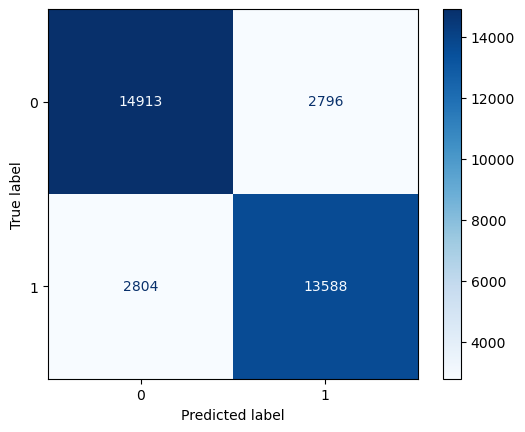

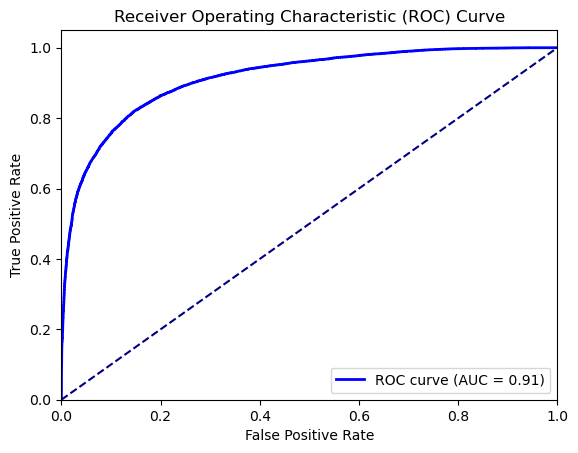

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84     17709
         1.0       0.83      0.83      0.83     16392

    accuracy                           0.84     34101
   macro avg       0.84      0.84      0.84     34101
weighted avg       0.84      0.84      0.84     34101



In [13]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict the labels for the test set
y_pred_probs = model.predict(X_test)  # Probabilities for the positive class
y_pred_classes = (y_pred_probs > 0.5).astype("int32")  # Binary predicted class labels

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot(cmap=plt.cm.Blues)
print('Confusion Matrix:')
print(conf_matrix)

# Calculate sensitivity, specificity, F1 score, precision, and recall
tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)

print(f'Sensitivity (Recall): {sensitivity}')
print(f'Specificity: {specificity}')
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')

# ROC and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = roc_auc_score(y_test, y_pred_probs)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred_classes))

In [14]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score, auc

# Calculate the metrics
test_loss, test_accuracy = model.evaluate(X_test, y_test)


# Predicted probabilities
y_pred_probs = model.predict(X_test)  # Probabilities for the positive class
y_pred_classes = (y_pred_probs > 0.5).astype("int32")  # Binary predicted class labels

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Extracting true positives, false positives, true negatives, and false negatives
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)

# Calculate specificity
specificity = tn / (tn + fp)

# Calculate F1 score, precision, and recall
f1 = f1_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)

# ROC and AUC for binary classification
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = roc_auc_score(y_test, y_pred_probs)

# Calculate Precision-Recall AUC
precision_rec, recall_rec, _ = precision_recall_curve(y_test, y_pred_probs)

# Ensure the precision and recall are sorted in decreasing order for precision
# and increasing order for recall (as required by AUC)
if precision_rec[0] < precision_rec[-1]:
    precision_rec = precision_rec[::-1]
    recall_rec = recall_rec[::-1]
print("Model: CNN (PTB-XL, Time)\n")
pr_auc = auc(recall_rec, precision_rec)

# Create a summary DataFrame for each model
model_summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Sensitivity (Recall)', 'Specificity', 'F1-Score', 'ROC AUC', 'Precision-Recall AUC'],
    'Score': [
        test_accuracy,
        sensitivity,
        specificity,
        f1,
        roc_auc,
        pr_auc
    ]
})

# Print the model summary
print(f"Model: {model}")
display(model_summary)


1066/1066 ━━━━━━━━━━━━━━━━━━━━ 33s 31ms/step - accuracy: 0.8525 - loss: 0.3739
1066/1066 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step
Model: CNN (PTB-XL, Time)

Model: <Sequential name=sequential, built=True>


,Metric,Score
0,Accuracy,0.835782
1,Sensitivity (Recall),0.828941
2,Specificity,0.842114
3,F1-Score,0.829143
4,ROC AUC,0.914392
5,Precision-Recall AUC,0.913872
